# Question Answering with PyTorch Transformers: Part 3

N.B. Please run the notebook "Questionable - Part 2" to generate the caches used in this one.

Article is pending

In [1]:
!pip install seaborn

     |████████████████████████████████| 215kB 1.1MB/s eta 0:00:01


In [2]:
import os
import random
import pandas as pd
import json
import sklearn
import spacy

import numpy as np
import torch
import torch.nn.functional as F
from itertools import islice
from tqdm import tqdm
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import *
%matplotlib inline

In [3]:
SQUAD_URL = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json"
SQUAD_TRAIN = "data/train-v2.0.json"
LEMMA_CACHE = "cache/lemmas.feather"
VECTOR_CACHE = "cache/vectors.pickle"

In [4]:
# This takes a while the first time, since from_pretrained() downloads and caches the model weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForQuestionAnswering \
    .from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad') \
    .to(device)

In [6]:
question_df = pd.read_feather("cache/question_context.feather")
question_df

,question,context
0,When did the last country to adopt the Gregori...,"""Old Style"" (OS) and ""New Style"" (NS) are some..."
1,When did the last country to adopt the Gregori...,"During the period between 1582, when the first..."
2,When did the last country to adopt the Gregori...,In conjunction with the system of months there...
3,When did the last country to adopt the Gregori...,Extending the Gregorian calendar backwards to ...
4,When did the last country to adopt the Gregori...,Most Western European countries changed the st...
5,When did the last country to adopt the Gregori...,The Gregorian calendar is a solar calendar. A ...
6,When did the last country to adopt the Gregori...,"Prior to 1917, Turkey used the lunar Islamic c..."
7,When did the last country to adopt the Gregori...,The Gregorian calendar improves the approximat...
8,When did the last country to adopt the Gregori...,Philip II of Spain decreed the change from the...
9,When did the last country to adopt the Gregori...,In addition to the change in the mean length o...


In [7]:
question, context = question_df[["question", "context"]].iloc[1]
question, context

('When did the last country to adopt the Gregorian calendar start using it?',
 'During the period between 1582, when the first countries adopted the Gregorian calendar, and 1923, when the last European country adopted it, it was often necessary to indicate the date of some event in both the Julian calendar and in the Gregorian calendar, for example, "10/21 February 1750/51", where the dual year accounts for some countries already beginning their numbered year on 1 January while others were still using some other date. Even before 1582, the year sometimes had to be double dated because of the different beginnings of the year in various countries. Woolley, writing in his biography of John Dee (1527–1608/9), notes that immediately after 1582 English letter writers "customarily" used "two dates" on their letters, one OS and one NS.')

In [8]:
# Example from https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering
input_text = "[CLS] " + question + " [SEP] " + context + " [SEP]"
input_ids = tokenizer.encode(input_text, add_special_tokens=False)
token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
input_ids[:10], token_type_ids[:20]

([101, 2043, 2106, 1996, 2197, 2406, 2000, 11092, 1996, 25847],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [9]:
with torch.no_grad():
    start_scores, end_scores = model(torch.tensor([input_ids], device=device),
                                     token_type_ids=torch.tensor([token_type_ids], device=device))
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
print(f'score: {torch.max(start_scores)}')

1923
score: 8.12308120727539


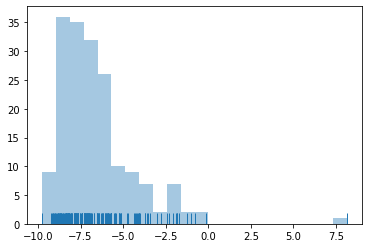

In [10]:
sns.distplot(start_scores.cpu(), kde=False, rug=True)

In [11]:
prefix = tokenizer.decode(input_ids[torch.argmax(start_scores)-8:torch.argmax(start_scores) ])
answer = tokenizer.decode(input_ids[torch.argmax(start_scores) : torch.argmax(end_scores)+1])
suffix = tokenizer.decode(input_ids[torch.argmax(end_scores)+1:torch.argmax(end_scores)+8 ])

"..." + prefix + " >>>" + answer + "<<< " + suffix + "..."

'...first countries adopted the gregorian calendar, and >>>1923<<< , when the last european country adopted...'

In [12]:
question, context = question_df[["question", "context"]].iloc[0]
question, context

('When did the last country to adopt the Gregorian calendar start using it?',
 '"Old Style" (OS) and "New Style" (NS) are sometimes added to dates to identify which system is used in the British Empire and other countries that did not immediately change. Because the Calendar Act of 1750 altered the start of the year, and also aligned the British calendar with the Gregorian calendar, there is some confusion as to what these terms mean. They can indicate that the start of the Julian year has been adjusted to start on 1 January (NS) even though contemporary documents use a different start of year (OS); or to indicate that a date conforms to the Julian calendar (OS), formerly in use in many countries, rather than the Gregorian calendar (NS).')

In [13]:
# Example from https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering
input_text = "[CLS] " + question + " [SEP] " + context + " [SEP]"
input_ids = tokenizer.encode(input_text, add_special_tokens=False)
token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]

1750
score: -1.3189575672149658


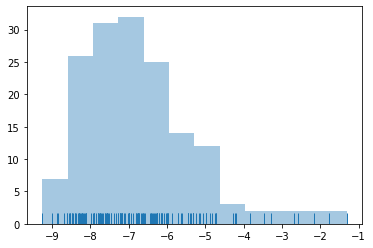

In [14]:
with torch.no_grad():
    start_scores, end_scores = model(torch.tensor([input_ids], device=device),
                                     token_type_ids=torch.tensor([token_type_ids], device=device))
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
print(f'score: {torch.max(start_scores)}')
sns.distplot(start_scores.cpu(), kde=False, rug=True)

## Prepare batch for inference

In [15]:
question_df["encoded"] = question_df.apply(lambda row: tokenizer.encode("[CLS] " + row["question"] + " [SEP] " + row["context"] + " [SEP]", add_special_tokens=False), axis=1)
question_df["tok_type"] = question_df.apply(lambda row: [0 if i <= row["encoded"].index(102) else 1 for i in range(len(row["encoded"]))], axis=1)
question_df.iloc[:3]

,question,context,encoded,tok_type
0,When did the last country to adopt the Gregori...,"""Old Style"" (OS) and ""New Style"" (NS) are some...","[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,When did the last country to adopt the Gregori...,"During the period between 1582, when the first...","[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,When did the last country to adopt the Gregori...,In conjunction with the system of months there...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
%%time
with torch.no_grad():
    X = torch.nn.utils.rnn.pad_sequence([torch.tensor(row) for row in question_df["encoded"]], batch_first=True).to(device)
    T = torch.nn.utils.rnn.pad_sequence([torch.tensor(row) for row in question_df["tok_type"]], batch_first=True).to(device)
    start_scores, end_scores = model(X, token_type_ids=T)
    max_score, max_start = torch.max(start_scores, axis=1)
    soft_max = F.softmax(max_score, dim=0)

CPU times: user 17.6 ms, sys: 9.01 ms, total: 26.6 ms
Wall time: 25.4 ms


In [17]:
answer_df = question_df[["context", "encoded"]].copy()
answer_df["answer_score"] = max_score.cpu().numpy()
answer_df["answer_start"] = max_start.cpu().numpy()
answer_df["answer_softmax"] = soft_max.cpu().numpy()
answer_df

,context,encoded,answer_score,answer_start,answer_softmax
0,"""Old Style"" (OS) and ""New Style"" (NS) are some...","[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",-1.351559,158,0.000063
1,"During the period between 1582, when the first...","[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",8.141850,33,0.834725
2,In conjunction with the system of months there...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",4.786897,138,0.029141
3,Extending the Gregorian calendar backwards to ...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",3.780915,53,0.010656
4,Most Western European countries changed the st...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",2.163965,124,0.002115
5,The Gregorian calendar is a solar calendar. A ...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",-0.118183,161,0.000216
6,"Prior to 1917, Turkey used the lunar Islamic c...","[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",3.997778,125,0.013237
7,The Gregorian calendar improves the approximat...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",-1.628917,115,0.000048
8,Philip II of Spain decreed the change from the...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",6.112622,112,0.109714
9,In addition to the change in the mean length o...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",-1.050628,164,0.000085


In [18]:
max_len = torch.zeros_like(max_start)
for i in range(max_start.shape[0]):
    max_len[i] = torch.argmax(end_scores[i,max_start[i]:]) + 1
    
answer_df["answer_length"] = max_len.cpu().numpy()

In [19]:
answer_df = answer_df[answer_df.answer_score > 1.0].sort_values(by="answer_score", ascending=False)
answer_df.head()

,context,encoded,answer_score,answer_start,answer_softmax,answer_length
1,"During the period between 1582, when the first...","[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",8.141850,33,0.834725,1
8,Philip II of Spain decreed the change from the...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",6.112622,112,0.109714,4
2,In conjunction with the system of months there...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",4.786897,138,0.029141,4
6,"Prior to 1917, Turkey used the lunar Islamic c...","[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",3.997778,125,0.013237,3
3,Extending the Gregorian calendar backwards to ...,"[101, 2043, 2106, 1996, 2197, 2406, 2000, 1109...",3.780915,53,0.010656,4


In [20]:
def decode_answer(row):
    input_ids = row.encoded
    offset = row.answer_start
    length = np.clip(row.answer_length, 0, 20)
    return tokenizer.decode(input_ids[offset:][:length])

In [21]:
answer_df["answer"] = answer_df.apply(decode_answer, axis=1)
answer_df[["answer_softmax", "answer_score", "answer"]].head()

,answer_softmax,answer_score,answer
1,0.834725,8.141850,1923
8,0.109714,6.112622,15 october 1582
2,0.029141,4.786897,4 october 1582
6,0.013237,3.997778,1 january 1926
3,0.010656,3.780915,15 october 1582


In [22]:
answer_df[["answer_softmax", "answer_score", "answer", "context"]].iloc[:3].to_dict(orient="records")

[{'answer_softmax': 0.8347248435020447,
  'answer_score': 8.141850471496582,
  'answer': '1923',
  'context': 'During the period between 1582, when the first countries adopted the Gregorian calendar, and 1923, when the last European country adopted it, it was often necessary to indicate the date of some event in both the Julian calendar and in the Gregorian calendar, for example, "10/21 February 1750/51", where the dual year accounts for some countries already beginning their numbered year on 1 January while others were still using some other date. Even before 1582, the year sometimes had to be double dated because of the different beginnings of the year in various countries. Woolley, writing in his biography of John Dee (1527–1608/9), notes that immediately after 1582 English letter writers "customarily" used "two dates" on their letters, one OS and one NS.'},
 {'answer_softmax': 0.109713613986969,
  'answer_score': 6.112621784210205,
  'answer': '15 october 1582',
  'context': 'Phili

## Bonus: Questionable Web Service

Start a terminal from the jupyter file manager and create a new Terminal to run:

```
pip install flask
python questionable.py
```

In [1]:
import requests
resp = requests.get("http://localhost:8765/answer", params=dict(
  q="When did the last country to adopt the Gregorian calendar start using it?"))
resp.json()

[{'context': 'During the period between 1582, when the first countries adopted the Gregorian calendar, and 1923, when the last European country adopted it, it was often necessary to indicate the date of some event in both the Julian calendar and in the Gregorian calendar, for example, "10/21 February 1750/51", where the dual year accounts for some countries already beginning their numbered year on 1 January while others were still using some other date. Even before 1582, the year sometimes had to be double dated because of the different beginnings of the year in various countries. Woolley, writing in his biography of John Dee (1527–1608/9), notes that immediately after 1582 English letter writers "customarily" used "two dates" on their letters, one OS and one NS.',
  'answer_score': 8.0448360443,
  'answer_softmax': 0.8096454144,
  'answer_start': 34,
  'answer_length': 1,
  'answer': '1923'},
 {'context': 'Philip II of Spain decreed the change from the Julian to the Gregorian calendar

In [2]:
! curl -G http://localhost:8765/answer \
        --data-urlencode "q=When did the last country to adopt the Gregorian calendar start using it?" \
        | json_pp

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1634  100  1634    0     0   2614      0 --:--:-- --:--:-- --:--:--  2610
[
   {
      "answer" : "1923",
      "answer_length" : 1,
      "answer_score" : 8.0448360443,
      "answer_softmax" : 0.8096454144,
      "answer_start" : 34,
      "context" : "During the period between 1582, when the first countries adopted the Gregorian calendar, and 1923, when the last European country adopted it, it was often necessary to indicate the date of some event in both the Julian calendar and in the Gregorian calendar, for example, \"10/21 February 1750/51\", where the dual year accounts for some countries already beginning their numbered year on 1 January while others were still using some other date. Even before 1582, the year sometimes had to be double dated because of the different beginnings of the year in various countries. Woolle